# Amyloid Generator v1
DL, 071923

Makes amyloids from input pngs with defined tilts (for entertainment purposes only). Can morph between two pngs with very simple alpha blending. 

Input images can be drawn at https://www.pixilart.com/draw, set box size to square - 384x384 works well. Color in clear sections to white with the bucket tool. Download as .png and use as input.

TO DO:
- Other things to morph: cats, dogs, yoda, vader, ...?
- For morphing, implement Beier-Neely morphing algorithm? Or some other automated morpher?
- Add tilt

In [1]:
# Import helpful packages
import numpy as np
import scipy.ndimage as ndimage
from PIL import Image
import seaborn as sns
import mrcfile
from scipy.ndimage import gaussian_filter

In [31]:
# Helper functions
def preview_image(image, clear_background: bool = False):
    image_array = np.array(Image.open(image).convert('L'), dtype = np.float32)
    if clear_background:
        image_array[image_array == 0 ] = 255
    restored_image = Image.fromarray(image_array.astype(np.uint8))
    return restored_image    

def rotate_image(image, angle):
    # Convert angle to radians
    angle_rad = np.radians(angle)

    # Get image dimensions
    height, width = image.shape

    # Calculate the center point of the image
    center_x = width / 2
    center_y = height / 2

    # Create rotation matrix
    rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                                [np.sin(angle_rad), np.cos(angle_rad)]])

    # Generate new rotated image
    rotated_image = np.ones_like(image)*255
    for x in range(width):
        for y in range(height):
            # Shift coordinates to the center
            x_shifted = x - center_x
            y_shifted = y - center_y

            # Apply rotation transformation
            x_rotated, y_rotated = np.dot(rotation_matrix, [x_shifted, y_shifted])

            # Shift coordinates back to the original position and round to integers
            x_rotated = int(x_rotated + center_x)
            y_rotated = int(y_rotated + center_y)

            # Check bounds to avoid index out of range errors
            if 0 <= x_rotated < width and 0 <= y_rotated < height:
                rotated_image[y_rotated, x_rotated] = image[y, x]
    return rotated_image

def make_amyloid(image1: str, image2: str, twist: float, output_path: str, clear_background: bool = False, pixel_size: float = 0.727, gaussian_blur: bool = True, sigma: float = 0.5):
    # Read in initial images:
    img1 = np.array(Image.open(image1).convert('L'))
    img2 = np.array(Image.open(image2).convert('L'))
    if clear_background:
        img1[img1==0] = 255
        img2[img2==0] = 255

    # Generate series of images:
    num_slices = int(img1.shape[0]/7)+1
    alpha_list = np.linspace(0, 1, num = num_slices)
    blended_images = []
    for alpha in alpha_list:
        current_blend = (1 - alpha) * img1 + alpha * img2
        blended_images.append(current_blend)

    #Rotate image by angle
    rotated_images = []
    for angle in range(num_slices):
        rotated_images.append(rotate_image(blended_images[angle], twist*angle))

    #Write as volume data
    volume_data = np.zeros((img1.shape[0], img1.shape[0], img1.shape[0]), dtype = np.float32)
    for z_level in range(img1.shape[0]):
        if z_level%7 <=3:
            volume_data[:,:, z_level] = 255 - rotated_images[int(z_level/7)]
        else:
            volume_data[:,:, z_level] = np.zeros((img1.shape[0],img1.shape[0]), dtype = np.float32)
    volume_data_scaled = np.array(volume_data, dtype = np.float32)/(255*20) # scaled from 0 to 0.05
        
    # Apply gaussian blur to data
    if gaussian_blur:
        volume_data_scaled = gaussian_filter(volume_data_scaled, sigma)
    
    # Write to mrc
    pixel_size = pixel_size
    with mrcfile.new(output_path, overwrite = True) as mrc:
        mrc.set_data(volume_data_scaled)
        mrc.voxel_size = (pixel_size, pixel_size, pixel_size)
    
    # Plot central slice
    sns.heatmap(np.mean(volume_data_scaled[:, :, int(img1.shape[0]/2)-7:int(img1.shape[0]/2)], axis = 2))
    
def make_amyloid_endcap(image1: str, image2: str, twist: float, output_path: str, clear_background: bool = False, pixel_size: float = 0.727, gaussian_blur: bool = True, sigma: float = 0.5):
    # Read in initial images:
    img1 = np.array(Image.open(image1).convert('L'))
    img2 = np.array(Image.open(image2).convert('L'))
    if clear_background:
        img1[img1==0] = 255
        img2[img2==0] = 255

    # Generate series of images:
    num_slices = int(img1.shape[0]/7)+1
    alpha_list = np.linspace(0, 1, num = num_slices)
    blended_images = []
    for alpha in alpha_list:
        current_blend = (1 - alpha) * img1 + alpha * img2
        blended_images.append(current_blend)

    #Rotate image by angle
    rotated_images = []
    for angle in range(num_slices):
        rotated_images.append(rotate_image(blended_images[angle], twist*angle))
    
    #Write as volume data
    volume_data = np.zeros((img1.shape[0], img1.shape[0], img1.shape[0]), dtype = np.float32)
    for z_level in range(img1.shape[0]):
        if z_level%7 <=3 and z_level <= 6:
            volume_data[:,:, z_level] = 255 - rotated_images[int(z_level/7)]
        else:
            volume_data[:,:, z_level] = np.zeros((img1.shape[0],img1.shape[0]), dtype = np.float32)
    volume_data_scaled = np.array(volume_data, dtype = np.float32)/(255*20) # scaled from 0 to 0.05
    
    # Apply gaussian blur to data
    if gaussian_blur:
        volume_data_scaled = gaussian_filter(volume_data_scaled, sigma)

    # Write to mrc
    pixel_size = pixel_size
    with mrcfile.new(output_path, overwrite = True) as mrc:
        mrc.set_data(volume_data_scaled)
        mrc.voxel_size = (pixel_size, pixel_size, pixel_size)

In [33]:
def make_amyloid_sharp(image1: str, image2: str, twist: float, output_path: str, clear_background: bool = False, pixel_size: float = 0.727, gaussian_blur: bool = True, sigma: float = 0.5):
    # Read in initial images:
    img1 = np.array(Image.open(image1).convert('L'))
    img2 = np.array(Image.open(image2).convert('L'))
    if clear_background:
        img1[img1==0] = 255
        img2[img2==0] = 255

    # Generate series of images:
    num_slices = int(img1.shape[0]/7)+1
    alpha_list = np.linspace(0, 1, num = num_slices)
    blended_images = []
    for alpha in alpha_list:
        current_blend = (1 - alpha) * img1 + alpha * img2
        blended_images.append(current_blend)

    #Rotate image by angle
    rotated_images = []
    for angle in range(num_slices):
        rotated_images.append(rotate_image(blended_images[angle], twist*angle))

    #Write as volume data
    volume_data = np.zeros((img1.shape[0], img1.shape[0], img1.shape[0]), dtype = np.float32)
    for z_level in range(img1.shape[0]):
        if z_level%7 <=3:
            volume_data[:,:, z_level] = 255 - rotated_images[int(z_level/7)]
        else:
            volume_data[:,:, z_level] = np.zeros((img1.shape[0],img1.shape[0]), dtype = np.float32)
    volume_data_scaled = np.array(volume_data, dtype = np.float32)/(255*20) # scaled from 0 to 0.05
        
    # Apply gaussian blur to data
    if gaussian_blur:
        volume_data_scaled = np.abs(volume_data_scaled - gaussian_filter(volume_data_scaled, sigma)) 
    
    # Write to mrc
    pixel_size = pixel_size
    with mrcfile.new(output_path, overwrite = True) as mrc:
        mrc.set_data(volume_data_scaled)
        mrc.voxel_size = (pixel_size, pixel_size, pixel_size)
    
    # Plot central slice
    sns.heatmap(np.mean(volume_data_scaled[:, :, int(img1.shape[0]/2)-7:int(img1.shape[0]/2)], axis = 2))

# Main

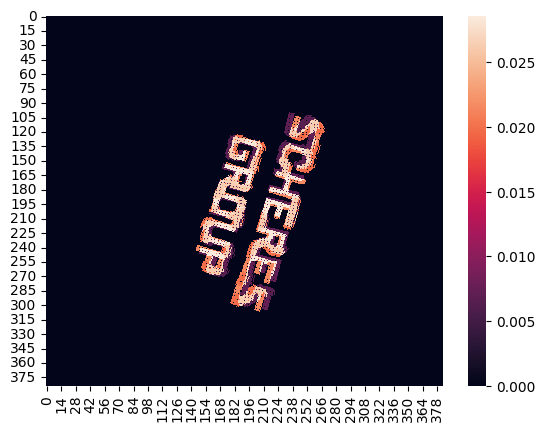

In [35]:
# Parameters:
image1_path = "Input/ScheresGroup3.png" # e.g. "Input/HIFIA.png"
image2_path = "Input/ScheresGroup3.png" # e.g. "Input/HIMAX.png", could be the same as image1_path
twist_angle = 4 # e.g. 4, in degrees
output_path = "Output/ScheresGroup3.mrc"# e.g. 'Output/MAFIA.mrc'
gaussian_blur = False # controls whether to pass through a gaussian_blur
sigma = 0.5 # controls radius of gaussian_blur
clear_background = False # set to true if images has clear background (some black may also disappear)

# Execute
make_amyloid(image1_path, image2_path, twist_angle, output_path, clear_background = clear_background, gaussian_blur = gaussian_blur, sigma = sigma)

# Testing

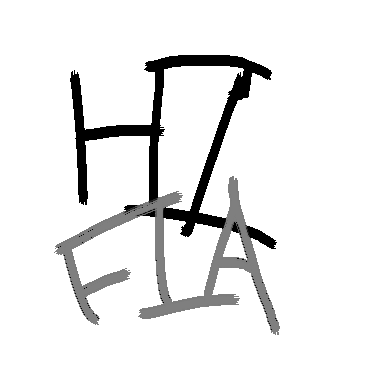

In [4]:
preview_image('Input/HIFIA.png')

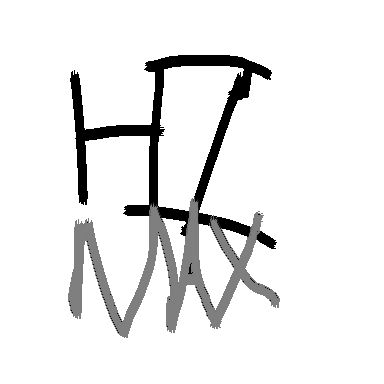

In [5]:
preview_image('Input/HIMAX.png')

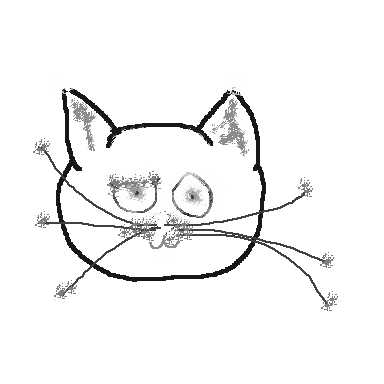

In [6]:
preview_image('Input/small_cat2.png', clear_background = True)

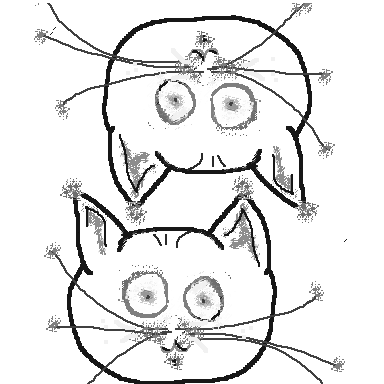

In [7]:
preview_image('Input/small_cat4.png', clear_background = True)

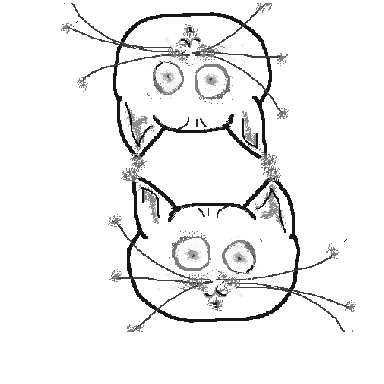

In [8]:
preview_image('Input/small_cat5.png', clear_background = True)

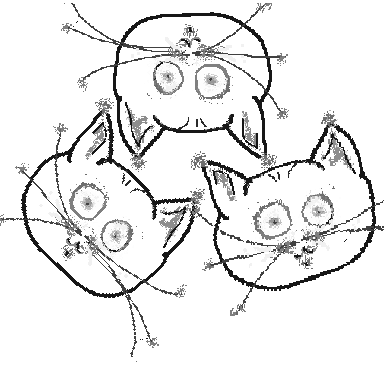

In [9]:
preview_image('Input/small_cat6.png', clear_background = True)

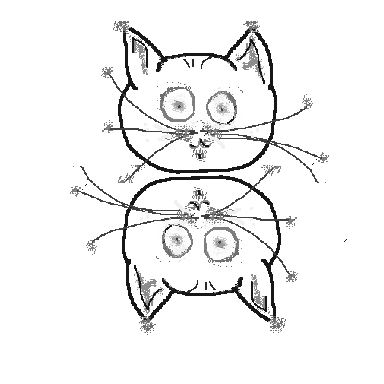

In [10]:
preview_image('Input/small_cat7.png', clear_background = True)

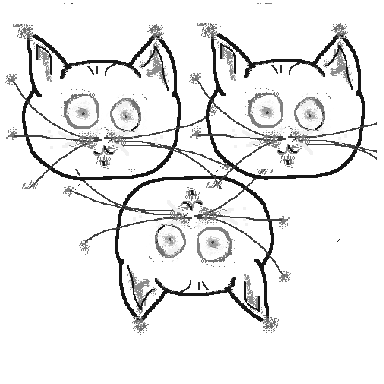

In [11]:
preview_image('Input/small_cat8.png', clear_background = True)

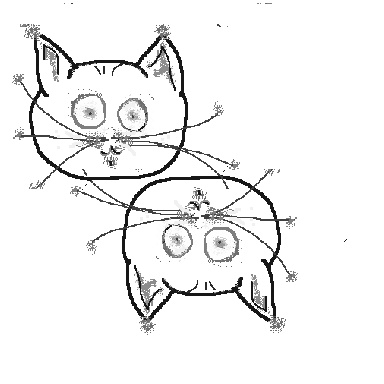

In [12]:
preview_image('Input/small_cat9.png', clear_background = True)

In [13]:
! ls "Input/"

Chao1.png         ScheresGroup.png  Yang1.png         small_cat4.png
Chao2.png         ScheresGroup2.png Yang2.png         small_cat5.png
DIANA.png         ScheresGroup3.png Yang3.png         small_cat6.png
DIANA2.png        ScheresGroup4.png small_cat1.png    small_cat7.png
HIFIA.png         Sjors1.png        small_cat2.png    small_cat8.png
HIMAX.png         Sjors2.png        small_cat3.png    small_cat9.png


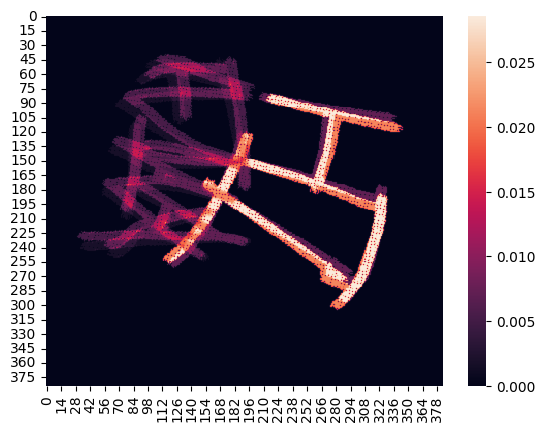

In [14]:
make_amyloid('Input/HIFIA.png', 'Input/HIMAX.png', 4, 'Output/MAFIA.mrc')

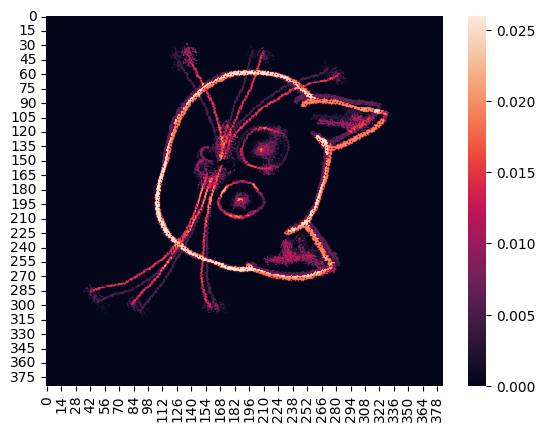

In [15]:
make_amyloid('Input/small_cat1.png', 'Input/small_cat2.png', 4, 'Output/blinkingcat.mrc', clear_background = True)

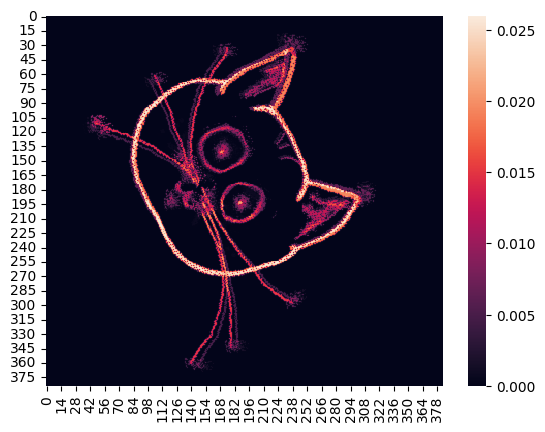

In [16]:
make_amyloid('Input/small_cat1.png', 'Input/small_cat3.png', 2.5, 'Output/fuzzycat.mrc', clear_background = True)

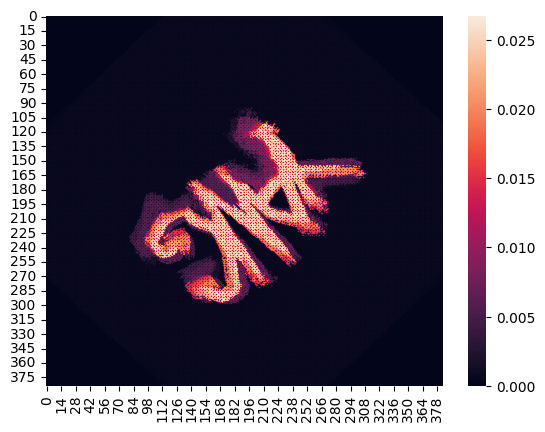

In [17]:
make_amyloid('Input/Yang3.png', 'Input/Yang3.png', 5, 'Output/Yang.mrc', clear_background = True)

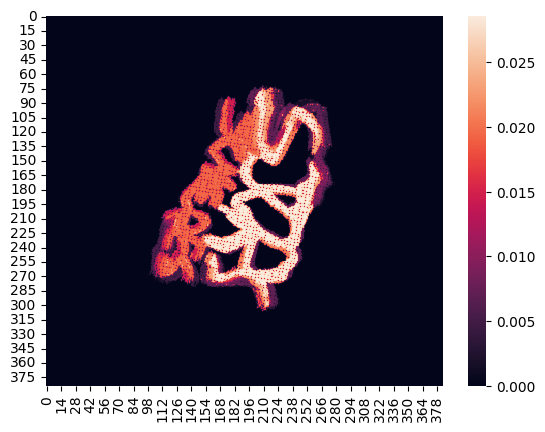

In [18]:
make_amyloid('Input/Sjors2.png', 'Input/Sjors2.png', 4, 'Output/Sjors.mrc')

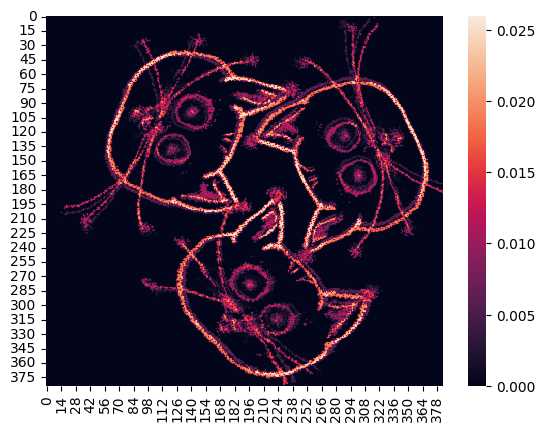

In [19]:
make_amyloid('Input/small_cat6.png', 'Input/small_cat6.png', 2.5, 'Output/cat_trimer1.mrc', clear_background = True)

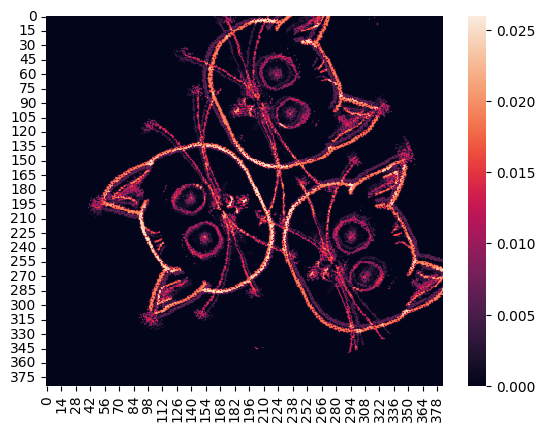

In [20]:
make_amyloid('Input/small_cat8.png', 'Input/small_cat8.png', 2.5, 'Output/cat_trimer2.mrc', clear_background = True)

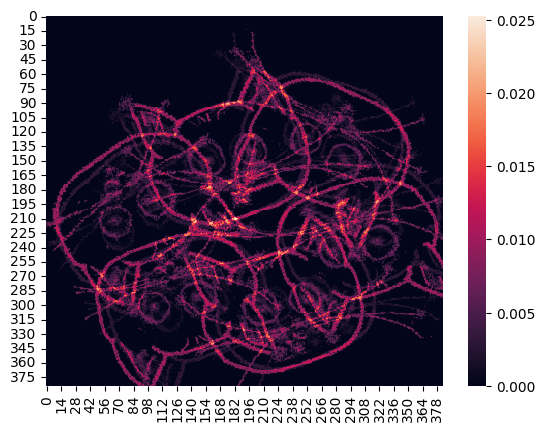

In [21]:
make_amyloid('Input/small_cat6.png', 'Input/small_cat8.png', 6, 'Output/cat_trimer_shift.mrc', clear_background = True)

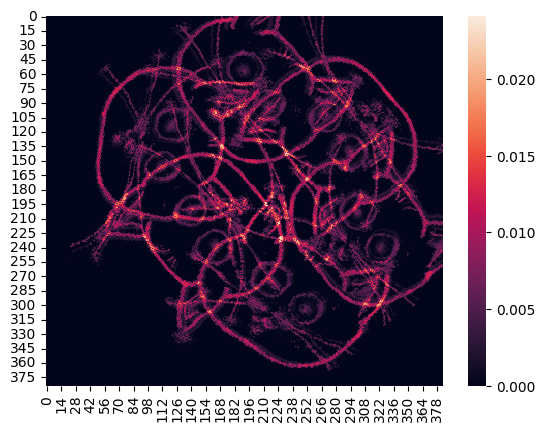

In [22]:
make_amyloid('Input/small_cat6.png', 'Input/small_cat8.png', 2, 'Output/cat_trimer_shift_small.mrc', clear_background = True)

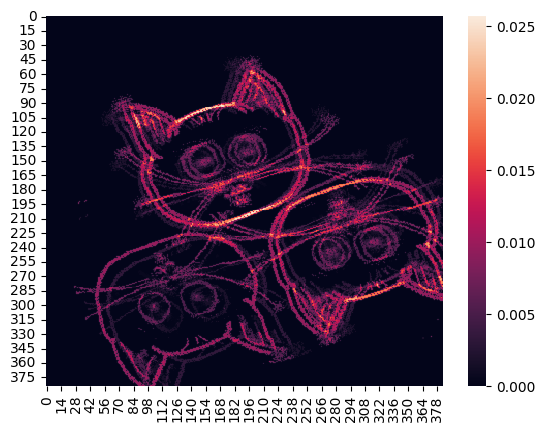

In [23]:
make_amyloid('Input/small_cat8.png', 'Input/small_cat9.png', 6, 'Output/cat_trimer_to_dimer.mrc', clear_background = True)

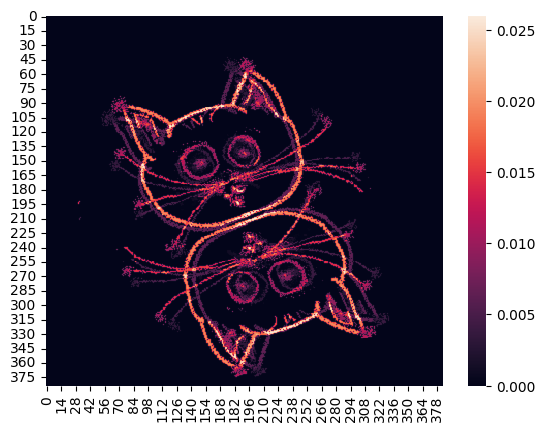

In [24]:
make_amyloid('Input/small_cat7.png', 'Input/small_cat7.png', 6, 'Output/cat_dimer1.mrc', clear_background = True)

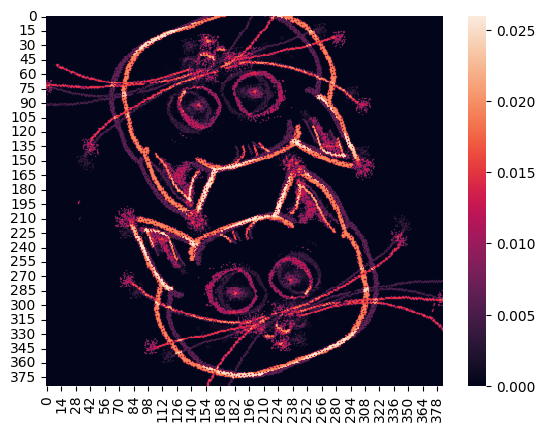

In [25]:
make_amyloid('Input/small_cat4.png', 'Input/small_cat4.png', 6, 'Output/cat_dimer2.mrc', clear_background = True)

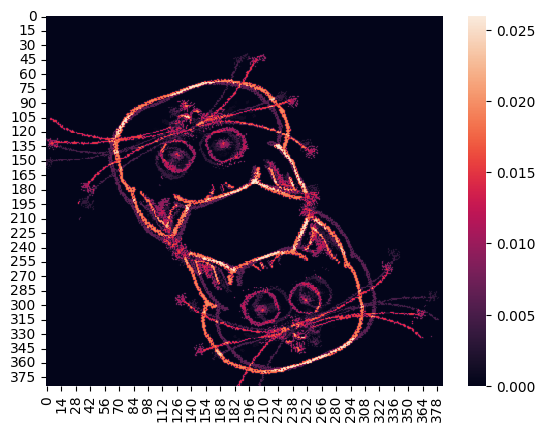

In [26]:
make_amyloid('Input/small_cat5.png', 'Input/small_cat5.png', 6, 'Output/cat_dimer3.mrc', clear_background = True)

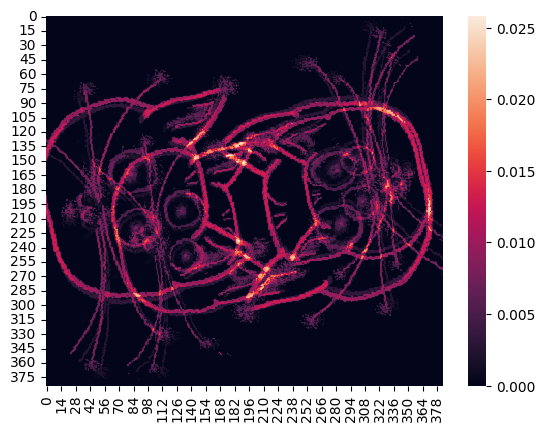

In [27]:
make_amyloid('Input/small_cat4.png', 'Input/small_cat5.png', 3, 'Output/cat_dimer2_to_3.mrc', clear_background = True)

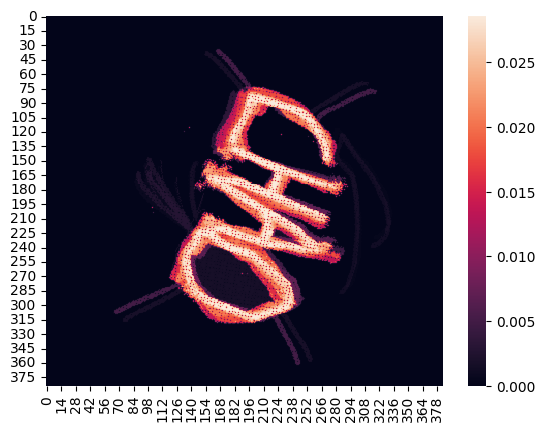

In [28]:
make_amyloid('Input/Chao1.png', 'Input/Chao2.png', 4, 'Output/Chao.mrc')

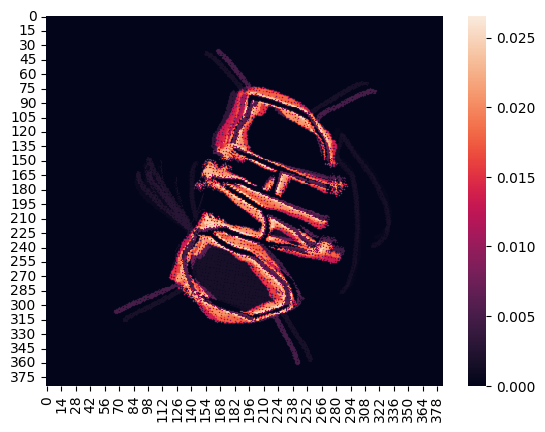

In [29]:
make_amyloid('Input/Chao1.png', 'Input/Chao2.png', 4, 'Output/Chao_hollow_center.mrc', clear_background = True)

In [32]:
# Parameters:
image1_path = "Input/ScheresGroup3.png" # e.g. "Input/HIFIA.png"
image2_path = "Input/ScheresGroup3.png" # e.g. "Input/HIMAX.png", could be the same as image1_path
twist_angle = 4 # e.g. 4, in degrees
output_path = "Output/ScheresGroup3endcap.mrc"# e.g. 'Output/MAFIA.mrc'
clear_background = False # set to true if images has clear background (some black may also disappear)

# Execute
make_amyloid_endcap(image1_path, image2_path, twist_angle, output_path, clear_background = clear_background)